# DO Compliance

A simple notebook to generate dissolved oxygen depletion plots as compared with the reference condition. Ecology only looks at depletions over a certain threshold when the existing value is below a certain water quality standard (which varies by location), but for my purposes of examining model behavior just looking at the DO difference is more useful. Incorporating the water quality standard into this process would not be that difficult if it's ever needed.

## Parameters

* `do_data_cdf`: The NetCDF file containing DO results. This is generated using one of the extraction notebooks.
* `start_date`: A date string to use as day 0 when formatting plot time axes.
* `domain_out_shp`: The shapefile that defines the node areas in the analysis domain. This is generated with [ProcessGrid.ipynb](ProcessGrid).
* `do_threshold`: The maximum difference between existing and reference that will lead to a noncompliance event. Used for calculating noncompliant area and duration.

In [1]:
do_data_cdf = "model_results/bottom do 2008.nc"
start_date = "2008-01-01"
domain_out_shp = "gis/ssm filled domain nodes.shp"

do_threshold = -0.2

from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
do_data = Dataset(do_data_cdf)
do_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(8760), node(6120)
    variables(dimensions): int32 node(node), float32 time(time), float32 existing(time, node), float32 reference(time, node)
    groups: 

In [3]:
dodeltas = (do_data['existing'][:].data - do_data['reference'][:].data)
dodeltas.shape

(8760, 6120)

In [4]:
domain = gpd.read_file(domain_out_shp)
domain.set_index('node_id', inplace=True)
domain.head()

,depth,geometry
node_id,,
4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5..."
4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5..."
4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5..."
4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5..."
4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5..."


,depth,geometry,values
node_id,,,
4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5...",-0.02329
4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5...",-0.02705
4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5...",-0.03071
4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5...",-0.03416
4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5...",-0.03071
...,...,...,...
16008,4.000000,"POLYGON ((498376.500 5233366.350, 498427.753 5...",-0.26422
16009,4.000000,"POLYGON ((498243.753 5233618.233, 498318.630 5...",-0.29797
16010,4.000000,"POLYGON ((497830.500 5233620.000, 498107.000 5...",-0.37170


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
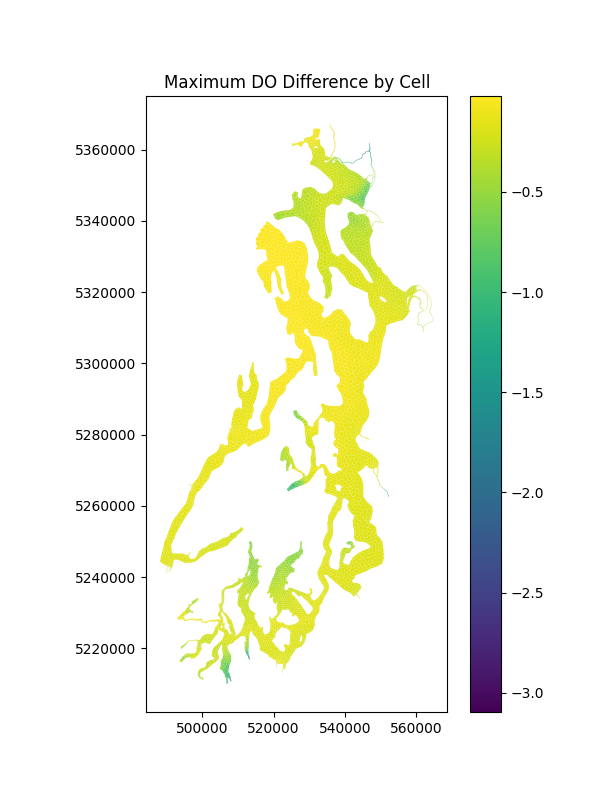

In [5]:
def do_plot(vals, title, ax=None):
    copy = domain.copy()
    copy['values'] = vals
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 8))
    p = copy.plot('values', ax=ax, markersize=1, legend=True)
    ax.set_title(title)
    ax.ticklabel_format(style='plain')
    return copy

do_plot(dodeltas.min(axis=0), "Maximum DO Difference by Cell")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
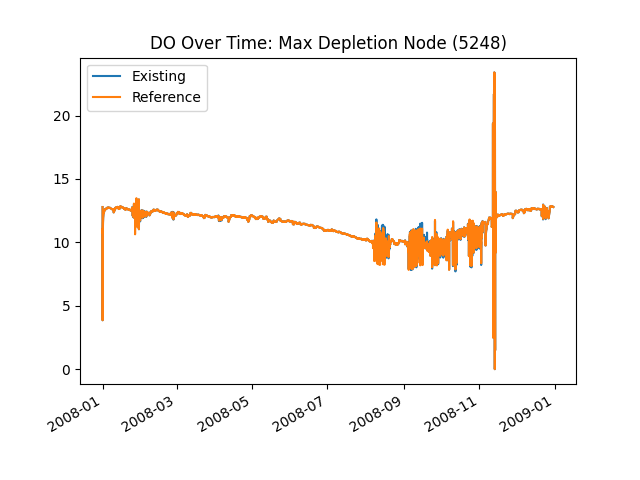

In [6]:
max_depletion_time = int(dodeltas.argmin()/dodeltas.shape[1])
max_depletion_cell = dodeltas[max_depletion_time,:].argmin()
fig, ax = plt.subplots()
times = do_data['time'][:]
dates = pd.Timestamp(start_date) + pd.to_timedelta(times, 'd')
ax.plot(dates, do_data['existing'][:,max_depletion_cell], label="Existing")
ax.plot(dates, do_data['reference'][:,max_depletion_cell], label="Reference")
ax.set(title="DO Over Time: Max Depletion Node ({0})".format(max_depletion_cell))
ax.legend()
fig.autofmt_xdate()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
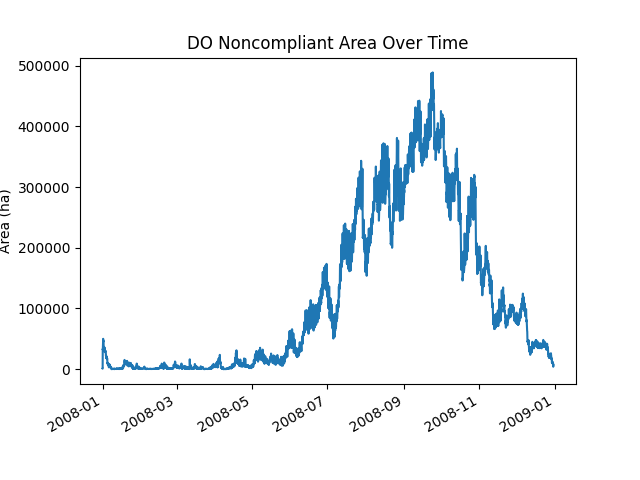

In [7]:
# Representative areas of each node
areas = domain.loc[do_data['node'][:].data].area

noncompl_area = []
for t in range(dodeltas.shape[0]):
    noncompl_area.append(areas.loc[dodeltas[t,:] < do_threshold].sum() / 1000)
fig, ax = plt.subplots()
ax.plot(dates, noncompl_area)
ax.set(title="DO Noncompliant Area Over Time", ylabel="Area (ha)")
fig.autofmt_xdate()

,depth,geometry,values
node_id,,,
4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5...",-0.01227
4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5...",-0.01477
4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5...",-0.01812
4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5...",-0.01427
4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5...",-0.01360
...,...,...,...
16008,4.000000,"POLYGON ((498376.500 5233366.350, 498427.753 5...",-0.01568
16009,4.000000,"POLYGON ((498243.753 5233618.233, 498318.630 5...",-0.08504
16010,4.000000,"POLYGON ((497830.500 5233620.000, 498107.000 5...",-0.03541


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
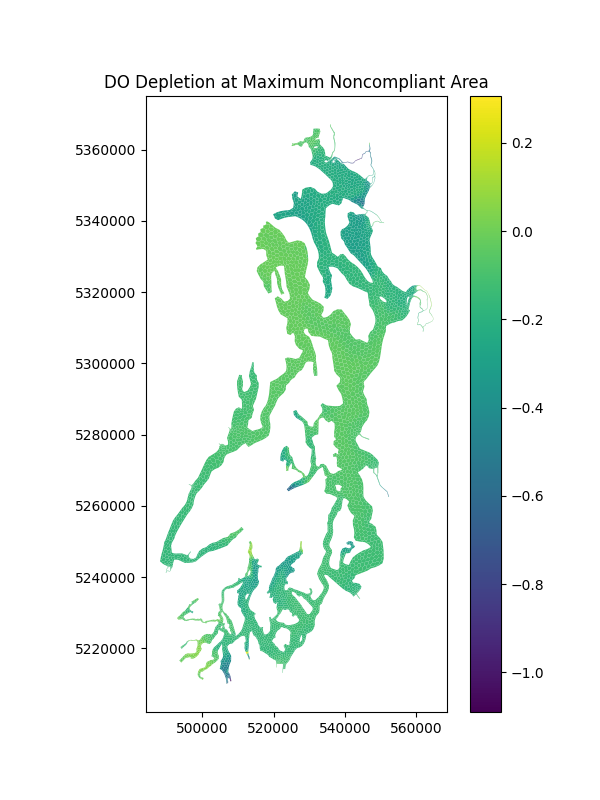

In [8]:
do_plot(dodeltas[np.argmax(noncompl_area),:], "DO Depletion at Maximum Noncompliant Area")

,depth,geometry,values
node_id,,,
4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5...",0.000000
4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5...",0.000000
4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5...",0.000000
4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5...",0.000000
4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5...",0.000000
...,...,...,...
16008,4.000000,"POLYGON ((498376.500 5233366.350, 498427.753 5...",2.750000
16009,4.000000,"POLYGON ((498243.753 5233618.233, 498318.630 5...",8.416667
16010,4.000000,"POLYGON ((497830.500 5233620.000, 498107.000 5...",12.625000


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
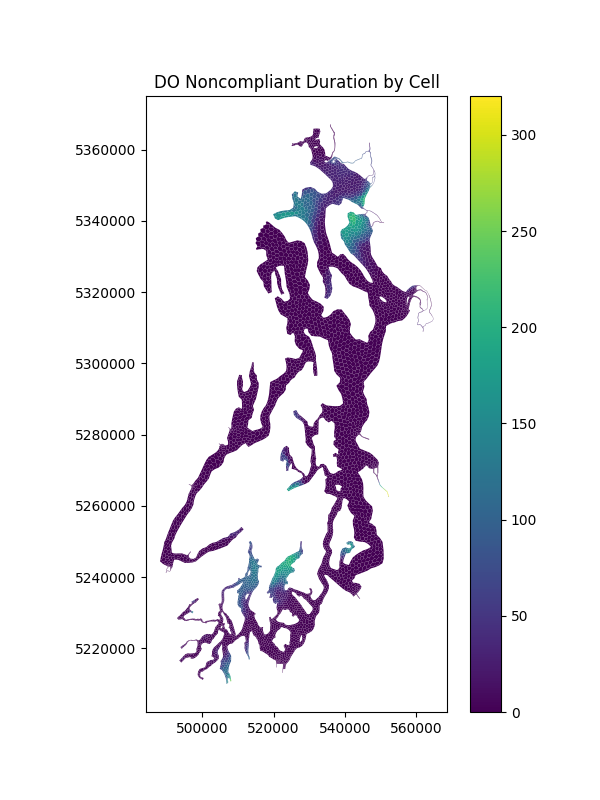

In [9]:
durations = []
for i in range(dodeltas.shape[1]):
    durations.append(np.count_nonzero(dodeltas[:,i] < do_threshold) / 24)
do_plot(durations, "DO Noncompliant Duration by Cell")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
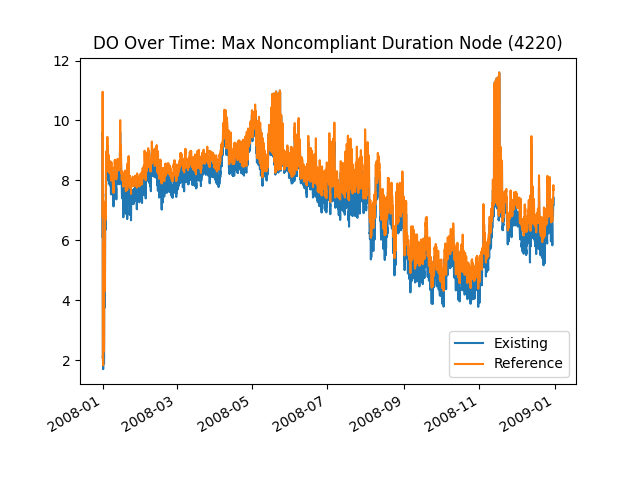

In [10]:
max_duration_cell = np.argmax(durations)
fig, ax = plt.subplots()
ax.plot(dates, do_data['existing'][:,max_duration_cell], label="Existing")
ax.plot(dates, do_data['reference'][:,max_duration_cell], label="Reference")
ax.set(title="DO Over Time: Max Noncompliant Duration Node ({0})".format(max_duration_cell))
ax.legend()
fig.autofmt_xdate()